In [1]:
import datetime
import warnings

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import skorch

from dataset import StockDataset
from denoising.autoencoder import *

from yahoo_fin_api import load_df

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
DATE_STR = '28022023-024108'
CONV1_KERNEL = 51
CONV2_KERNEL = 51
CONV3_KERNEL = 51

cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)

cnn_encoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-encoder.pt')), 
cnn_decoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-decoder.pt'))

<All keys matched successfully>

In [11]:
DATE_STR = '28022023-151344'
CONV1_KERNEL = 51
CONV2_KERNEL = 51
CONV3_KERNEL = 51

cnn_encoder = CnnEncoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)
cnn_decoder = CnnDecoder(CONV1_KERNEL, CONV2_KERNEL, CONV3_KERNEL)

cnn_encoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-encoder.pt')), 
cnn_decoder.load_state_dict(torch.load(f'./model-dir/{DATE_STR}-cnn-decoder.pt'))

<All keys matched successfully>

In [12]:
cnn_encoder.eval(), cnn_decoder.eval()

(CnnEncoder(
   (encoder_cnn): Sequential(
     (0): Conv1d(1, 8, kernel_size=(51,), stride=(1,), padding=(51,))
     (1): ReLU(inplace=True)
     (2): Conv1d(8, 16, kernel_size=(51,), stride=(1,), padding=(51,))
     (3): ReLU(inplace=True)
     (4): Conv1d(16, 32, kernel_size=(51,), stride=(1,), padding=(51,))
     (5): ReLU(inplace=True)
     (6): Conv1d(32, 64, kernel_size=(51,), stride=(1,), padding=(51,))
     (7): ReLU(inplace=True)
   )
 ),
 CnnDecoder(
   (decoder_cnn): Sequential(
     (0): ConvTranspose1d(64, 32, kernel_size=(51,), stride=(1,), padding=(51,))
     (1): ReLU(inplace=True)
     (2): ConvTranspose1d(32, 16, kernel_size=(51,), stride=(1,), padding=(51,))
     (3): ReLU(inplace=True)
     (4): ConvTranspose1d(16, 8, kernel_size=(51,), stride=(1,), padding=(51,))
     (5): ReLU(inplace=True)
     (6): ConvTranspose1d(8, 1, kernel_size=(51,), stride=(1,), padding=(51,))
   )
 ))

In [13]:
def get_data(data_name):
    df = load_df(f'data/{data_name}.csv')
    df[df.columns] = MinMaxScaler().fit_transform(df.values)
    data = df['Mean']
    data = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

    return df, data

In [14]:
snp_df, snp_data = get_data('snp')
gold_df, gold_data = get_data('gold')
currency_df, currency_data = get_data('krw-usd')

Although the distribution of gold, currency exchange would be very different with stock data, I used the gold and currency exchange data to check whether the autoencoder works properly to other similar data.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
snp_data = snp_data.to(device)
gold_data = gold_data.to(device)
currency_data = currency_data.to(device)

cnn_encoder = cnn_encoder.to(device)
cnn_decoder = cnn_decoder.to(device)

In [16]:
def predict(df, data):
    output = cnn_decoder(cnn_encoder(data)).detach().cpu().numpy().squeeze()
    df['CNNPredMean'] = output

    return df

In [17]:
snp_df = predict(snp_df, snp_data)
currency_df = predict(currency_df, currency_data)
gold_df = predict(gold_df, gold_data)

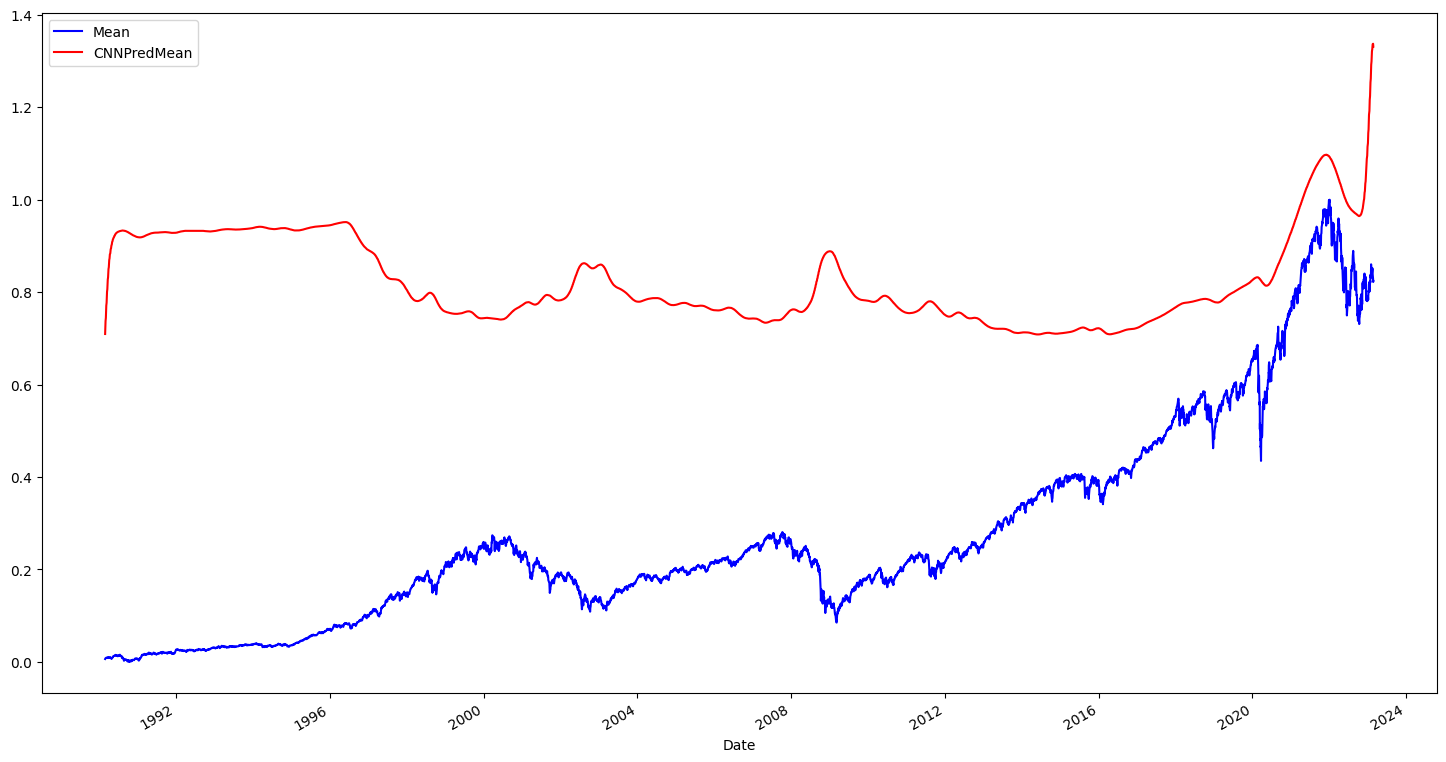

In [18]:
_ = snp_df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(18, 10))

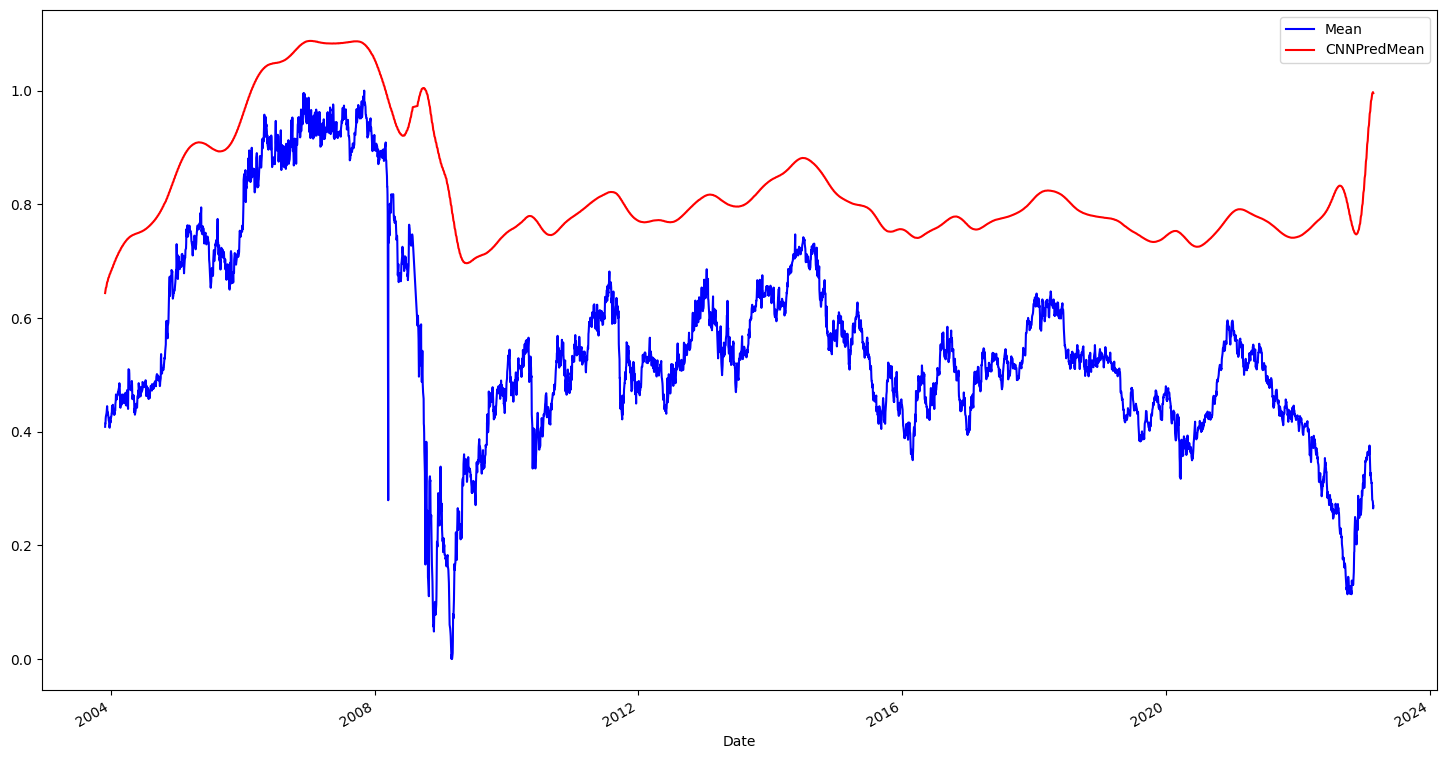

In [10]:
_ = currency_df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(18, 10))

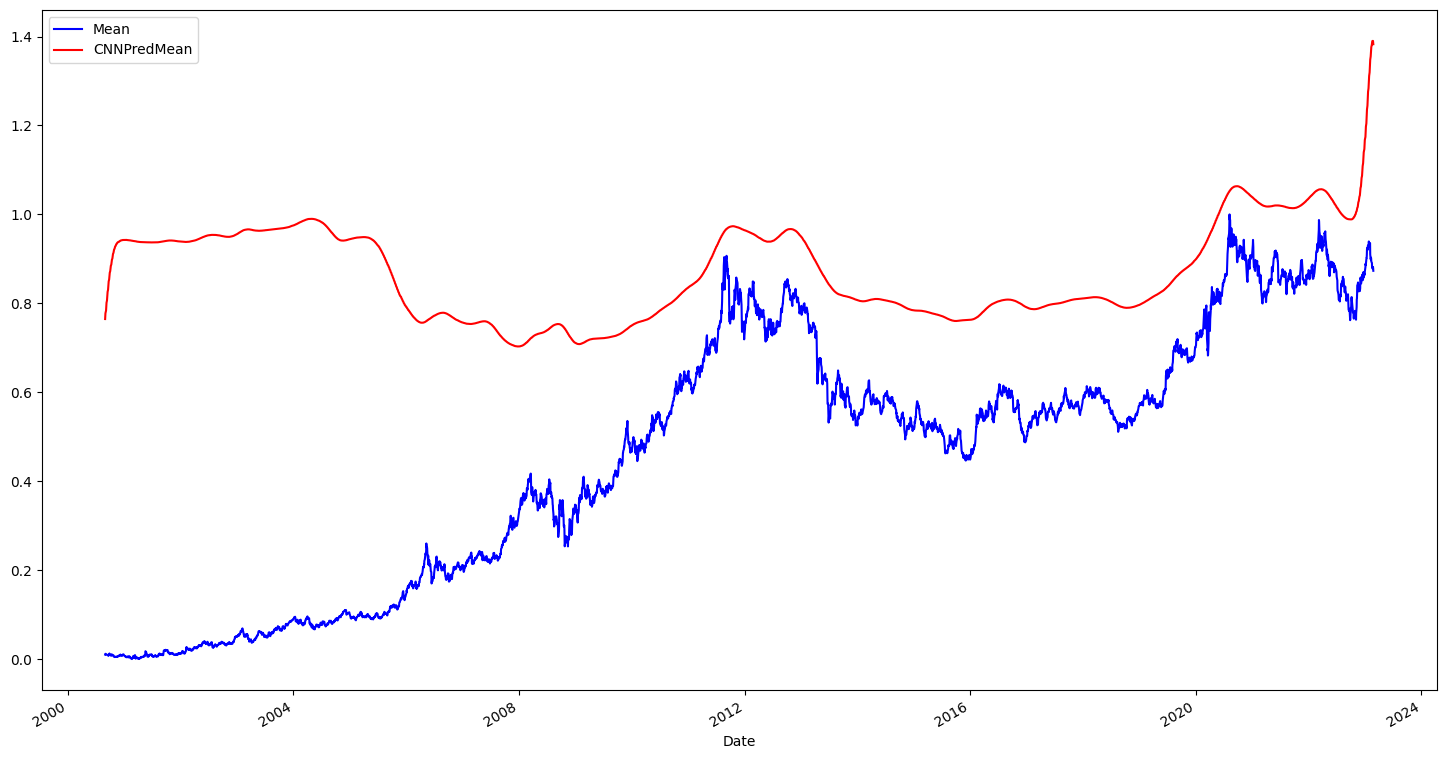

In [11]:
_ = gold_df[['Mean', 'CNNPredMean']].plot(color=['b', 'r'], figsize=(18, 10))

Of course, autoencoder seems not working for other types of data. We can see this as overfitting.